## Importações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import time
import glob
import random
import scipy
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import affine_transform

import pandas as pd

# Ensure unique name for TensorBoard logs
NAME = "Tcc_cnn_64_{}".format(int(time.time()))


## Configurações

### Utilização da GPU

In [2]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    

print(tf.test.is_built_with_cuda())

[]
Num GPUs Available:  0
Please install GPU version of TF
False


### Carregamento dos arquivos

In [3]:
all_traning_paths = glob.glob('DATASETS/TRAINING/*/*.jpg')
all_val_paths = glob.glob('DATASETS/VALIDATION/*/*.jpg')

### Aplicação de filtro para reduzir ruído

DATASETS/TRAINING\WITHOUT CANCER\2-224 (1).jpg


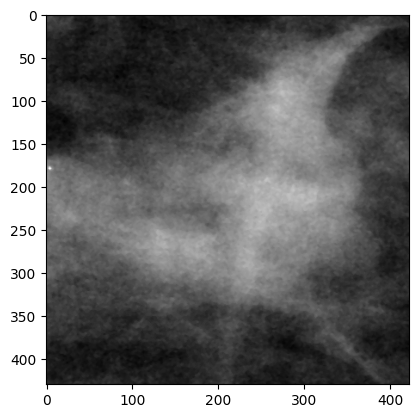

In [4]:
img_path=random.choice(all_traning_paths)
cropped_img = Image.open(img_path)

gray = cropped_img.convert('L')
median = cv2.medianBlur(np.array(gray), 3)
print(img_path)
plt.imshow(median, cmap='gray')

### Criação de datagens

In [5]:
datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen_32 = datagen_resnet.flow_from_directory('DATASETS/TRAINING/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=32 
                            )


validation_gen_32 = datagen_resnet.flow_from_directory('DATASETS/VALIDATION/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=32
                            )

test_gen = datagen_resnet.flow_from_directory('DATASETS/TESTING/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=16,
                            
                            )

Found 622 images belonging to 2 classes.


Found 544 images belonging to 2 classes.
Found 389 images belonging to 2 classes.


## Modelo

### Geração do modelo base com base na ResNet50

In [6]:
base_model=ResNet50(include_top=False,
                    input_shape=(224,224,3)
)

### Congelamento de camadas

In [7]:
for layer in base_model.layers:
    layer.trainable=False

### Configuração do Tensor Board

In [8]:
tensorBoard = TensorBoard(log_dir='logs/{}'.format(NAME))

### Criação de modelo sequencial com base no modelo 'base'

In [9]:
modelo_op = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.2),
                     Dense(64, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

modelo_op.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

### Compilação do modelo

In [10]:
modelo_op.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

### Treinamento do modelo

In [11]:

history_op = modelo_op.fit(train_gen_32, 
           validation_data=validation_gen_32,
           epochs=15,
           batch_size=32,
           callbacks=[tensorBoard]
        )

Epoch 1/15


20/20 [==============================] - 182s 9s/step - loss: 0.8564 - accuracy: 0.5305 - val_loss: 0.9038 - val_accuracy: 0.3805
Epoch 2/15
20/20 [==============================] - 176s 9s/step - loss: 0.7174 - accuracy: 0.5820 - val_loss: 0.7087 - val_accuracy: 0.5202
Epoch 3/15
20/20 [==============================] - 177s 9s/step - loss: 0.6754 - accuracy: 0.5965 - val_loss: 0.7471 - val_accuracy: 0.4596
Epoch 4/15
20/20 [==============================] - 173s 9s/step - loss: 0.6592 - accuracy: 0.6270 - val_loss: 0.6838 - val_accuracy: 0.5846
Epoch 5/15
20/20 [==============================] - 175s 9s/step - loss: 0.6286 - accuracy: 0.6495 - val_loss: 0.7033 - val_accuracy: 0.5404
Epoch 6/15
20/20 [==============================] - 162s 8s/step - loss: 0.6119 - accuracy: 0.6672 - val_loss: 0.7009 - val_accuracy: 0.5386
Epoch 7/15
20/20 [==============================] - 172s 9s/step - loss: 0.5958 - accuracy: 0.6865 - val_loss: 0.6963 - val_accuracy: 0.5515
Epoch 8/15


### Salvando o modelo e obtendo gráficos

C:\Users\Giovanna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Axes: >

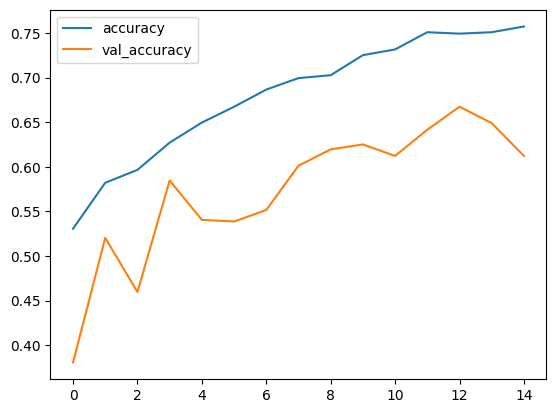

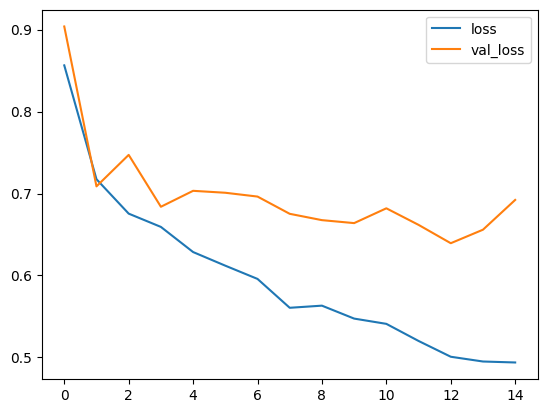

In [12]:
modelo_op.save('models/best_model_epoch.h5')

df = pd.DataFrame(history_op.history)
df[['accuracy', 'val_accuracy']].plot()
df[['loss', 'val_loss']].plot()

## Avaliação

### Carregamento do modelo e Realização de predições

In [13]:
# carregando o modelo
modelo_op = tf.keras.models.load_model('models/best_model_epoch.h5')
predictions = modelo_op.predict(test_gen, verbose=1)


25/25 [==============================] - 56s 2s/step


### Geração da Matriz de Confusão

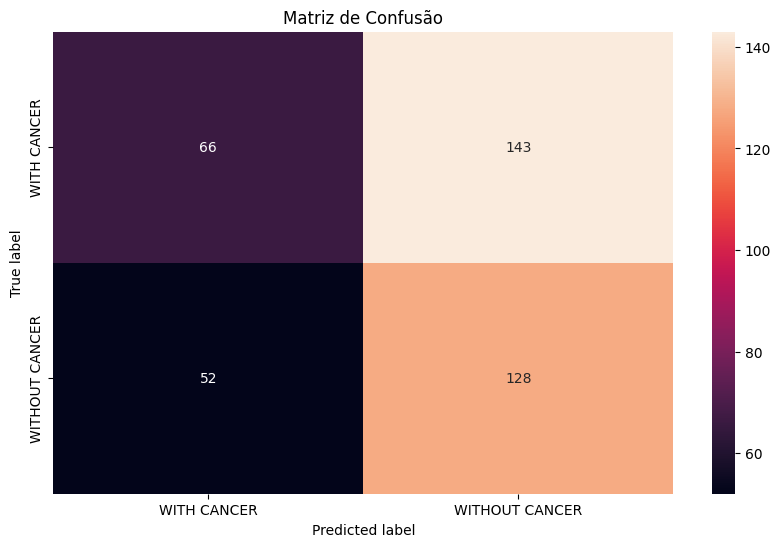

Verdadeiro Positivo (TP): 128
Verdadeiro Negativo (TN): 66
Falso Positivo (FP): 143
Falso Negativo (FN): 52


,WITH CANCER,WITHOUT CANCER
WITH CANCER,66,143
WITHOUT CANCER,52,128


                WITH CANCER  WITHOUT CANCER
WITH CANCER              66             143
WITHOUT CANCER           52             128


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Obtenha as labels automaticamente
class_labels = list(test_gen.class_indices.keys())

test_set = test_gen
test_set.reset()
y_pred = np.argmax(predictions, axis=-1)

y_test = test_gen.labels
cm = confusion_matrix(y_test,y_pred)

# Construa o DataFrame para o seaborn
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(cm_df, annot=True, fmt='d')  # fmt='d' para números inteiros
plt.title('Matriz de Confusão')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


TP = cm[1, 1]  # Verdadeiro Positivo
TN = cm[0, 0]  # Verdadeiro Negativo
FP = cm[0, 1]  # Falso Positivo
FN = cm[1, 0]  # Falso Negativo

print(f"Verdadeiro Positivo (TP): {TP}")
print(f"Verdadeiro Negativo (TN): {TN}")
print(f"Falso Positivo (FP): {FP}")
print(f"Falso Negativo (FN): {FN}")

display(cm_df)
print(cm_df)

### Geração de métricas a partir da matriz de confusão 

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
classes_name = ('cancer', 'sem cancer')
height, width = (224, 224)


test_set = test_gen
test_set.reset()
y_pred = np.argmax(predictions, axis=-1)

y_test = test_gen.labels
cm = confusion_matrix(y_test,y_pred)



cm2 = classification_report(test_gen.classes, y_pred)

print(classification_report(test_gen.classes, y_pred))


file = open('time_bin_metrics.txt', 'w')
file.write('tempo %s' % cm2)
file.close()

              precision    recall  f1-score   support

           0       0.56      0.32      0.40       209
           1       0.47      0.71      0.57       180

    accuracy                           0.50       389
   macro avg       0.52      0.51      0.49       389
weighted avg       0.52      0.50      0.48       389



### Hold out

In [16]:
# pegando o score do modelo
score = modelo_op.evaluate(test_gen, verbose=1)
print("SCORE:",score)

25/25 [==============================] - 58s 2s/step - loss: 0.6210 - accuracy: 0.6787
SCORE: [0.6209847927093506, 0.6786632537841797]


## Predições

In [17]:
def predicao(modelo, path):
    image = Image.open(path)

# Redimensione a imagem
    resized_image = image.resize((224, 224))

    # Certifique-se de que a imagem seja colorida (3 canais)
    if resized_image.mode == 'L':
        # Converta a imagem em escala de cinza em uma imagem RGB (colorida)
        resized_image = resized_image.convert('RGB')

    # Converta a imagem redimensionada em uma matriz NumPy
    np_array = np.array(resized_image)

    
    img_np = preprocess_input(np_array)
    imp_np2=img_np.reshape(1,224,224,3)
    result = modelo_op.predict(imp_np2)
    id_max= result[0].argmax()
    index_to_class = {v: k for k, v in train_gen_32.class_indices.items()}
    plt.title(f'Resultado: {index_to_class[id_max]}')
    plt.imshow(resized_image)
    plt.show()

DATASETS/TESTING\WITHOUT-CANCER\2-202.jpg
1/1 [==============================] - 0s 23ms/step


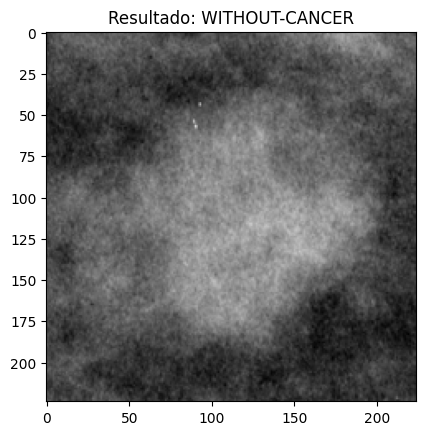

DATASETS/TESTING\WITHOUT-CANCER\2-086.jpg
1/1 [==============================] - 0s 22ms/step


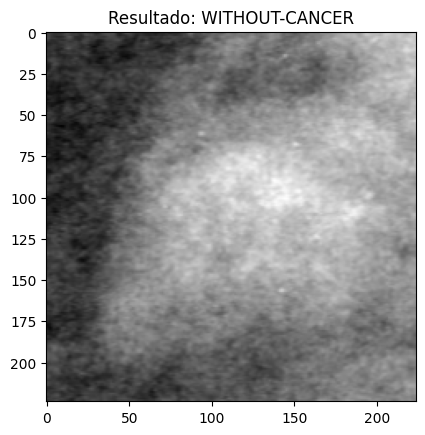

DATASETS/TESTING\WITHOUT-CANCER\1-277 (1).jpg
1/1 [==============================] - 0s 21ms/step


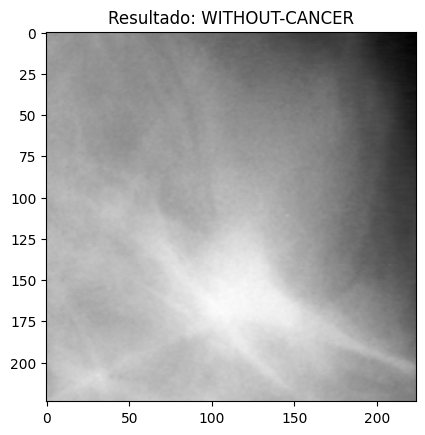

DATASETS/TESTING\WITHOUT-CANCER\2-010.jpg
1/1 [==============================] - 0s 20ms/step


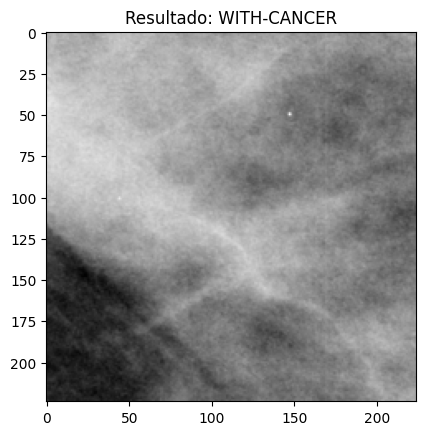

DATASETS/TESTING\WITHOUT-CANCER\2-171 (3).jpg
1/1 [==============================] - 0s 20ms/step


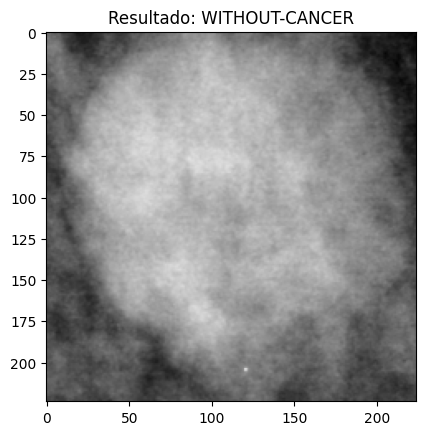

DATASETS/TESTING\WITH-CANCER\2-144 (1).jpg
1/1 [==============================] - 0s 20ms/step


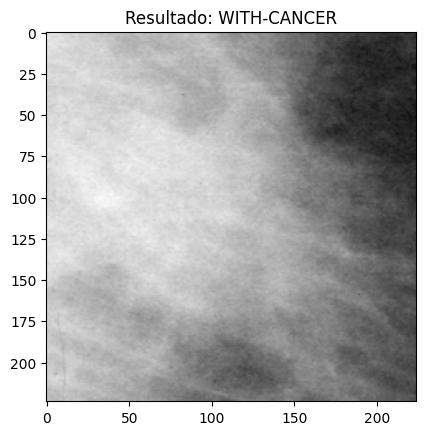

DATASETS/TESTING\WITH-CANCER\2-183.jpg
1/1 [==============================] - 0s 22ms/step


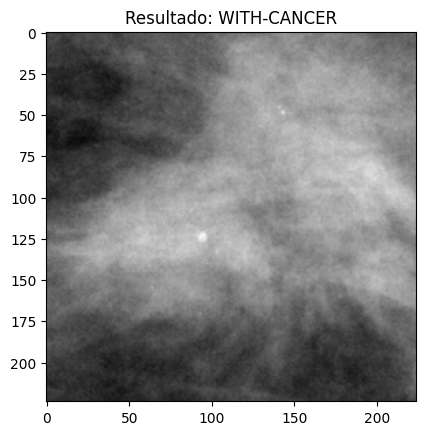

DATASETS/TESTING\WITHOUT-CANCER\2-140.jpg
1/1 [==============================] - 0s 31ms/step


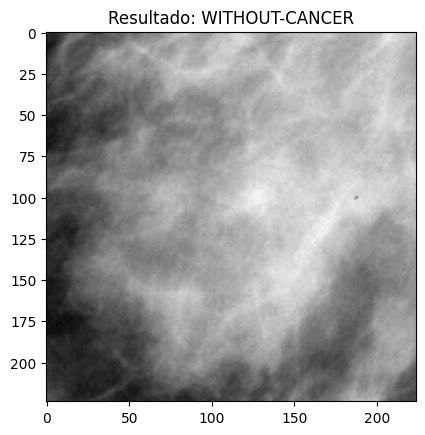

In [ ]:

# pegando 10 cminhos aliatorios para predição e moreando o resultado
all_test_paths = glob.glob('DATASETS/TESTING/*/*.jpg')
for i in range(8):
    img_path=random.choice(all_test_paths)
    print(img_path)
    predicao(modelo_op, img_path)